In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = yf.download("LUNA1-USD", start="2021-03-31", end="2022-03-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
data['Adj Close'].head()

Date
2021-03-30    18.669039
2021-03-31    18.700575
2021-04-01    18.516495
2021-04-02    18.566605
2021-04-03    18.141928
Name: Adj Close, dtype: float64

In [4]:
data['Adj Close'].tail()

Date
2022-03-26     91.387917
2022-03-27     94.151543
2022-03-28     97.328468
2022-03-29    108.988426
2022-03-30    106.015793
Name: Adj Close, dtype: float64

In [5]:
S = data['Adj Close'][-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ 106.02 .


In [9]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
vol_h = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is 166.96 %


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7B30BB240>],
      dtype=object)

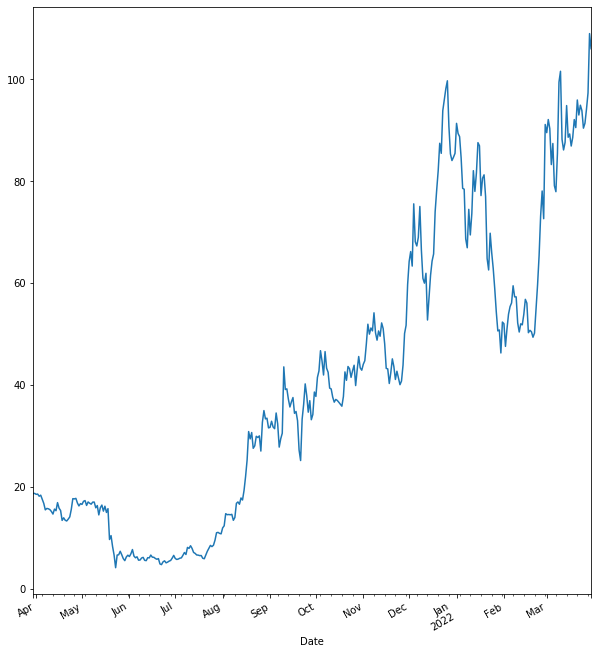

In [7]:
data['Adj Close'].plot(figsize=(10, 12), subplots=True)

# Binomial# 

In [11]:
S0 = 106.02             # spot stock price
K = 90.0               # strike
T = 1/12                # maturity 
r = 0.0172              # risk free rate 
sig = 1.66              # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff 

In [12]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [13]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [14]:
S

array([[106.02      , 139.81140709, 184.37303859, 243.13765284],
       [  0.        ,  80.3957319 , 106.02      , 139.81140709],
       [  0.        ,   0.        ,  60.96466428,  80.3957319 ],
       [  0.        ,   0.        ,   0.        ,  46.22994534]])

In [15]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.43212391552899043

In [16]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  9.6042681 ],
       [ 0.        ,  0.        ,  0.        , 43.77005466]])

In [17]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[12.01354403,  3.09425742,  0.        ,  0.        ],
       [ 0.        , 18.81076324,  5.45142897,  0.        ],
       [ 0.        ,  0.        , 28.99234599,  9.6042681 ],
       [ 0.        ,  0.        ,  0.        , 43.77005466]])

In [18]:
print('European ' + payoff, str( V[0,0]))

European put 12.013544031069054


# Monte Carlo

In [19]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [20]:
T = 1/12
r = 0.0172
sigma = 1.66
S0 = 106.02
K = 130

In [21]:
S = mcs_simulation_np(10000)

In [22]:
S = np.transpose(S)
S

array([[106.02      , 106.71869039, 105.82001847, ..., 230.67210121,
        230.06756877, 228.48949948],
       [106.02      , 106.32159823, 105.51876448, ...,  53.1379928 ,
         52.90259525,  53.17544708],
       [106.02      , 106.55521925, 107.24073555, ..., 117.27991344,
        116.54210795, 117.63569062],
       ...,
       [106.02      , 105.54898232, 104.94730124, ...,  76.47420931,
         76.67984629,  76.82620818],
       [106.02      , 106.12446751, 106.87449483, ..., 115.04542939,
        114.5952864 , 115.29443105],
       [106.02      , 105.70517051, 106.56184358, ...,  71.23740866,
         71.5019329 ,  71.40609044]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values of LUNA1-USD')

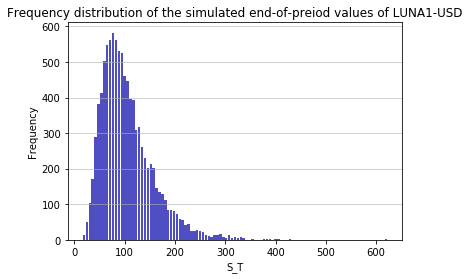

In [23]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values of LUNA1-USD')

In [24]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 36.39735783127151


In [25]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 12.21661118121055


# Black and Scholes

In [26]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [27]:
S = 106.02
K = 130
T = 1/12
r = 0.0172

In [28]:
call = euro_option_bs(S, K, T, r, vol_h, 'call')
print('The BS call price is', round(call, 2))

The BS call price is 12.47


In [29]:
put = euro_option_bs(S, K, T, r, vol_h, 'put')
print('The BS put price is', round(put, 2))

The BS put price is 36.26


In [61]:
S = np.linspace(50,170,101)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], 130, 1/12, 0.0172, 1.66, 'call')

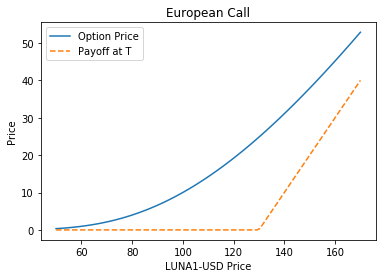

In [62]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-130,0), '--')
plt.xlabel('LUNA1-USD Price')
plt.ylabel('Price')
plt.title('European Call')
plt.legend(['Option Price','Payoff at T'])

In [63]:
S = np.linspace(50,170,101)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = euro_option_bs(S[i], 90, 1/12, 0.0172, 1.66, 'put')


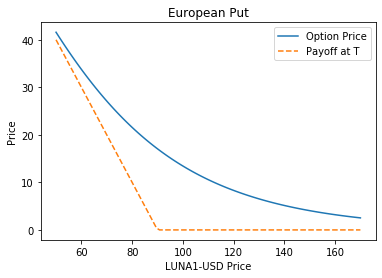

In [64]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.plot(S, np.maximum(90-S,0), '--')
plt.xlabel('LUNA1-USD Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

# Greeks

# Delta

In [49]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [50]:
delta(106.02, 130, 1/12, 0.0172, 0, 1.66, 'call')

0.42742933182163495

In [51]:
delta(106.02, 90, 1/12, 0.0172, 0, 1.66, 'put')

-0.2794593434694227

In [65]:
S = np.linspace(50,170,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 130, 1/12, 0.0172, 0, 1.66, 'call')
    Delta_Put [i] = delta(S[i], 90, 1/12, 0.0172, 0, 1.66, 'put')

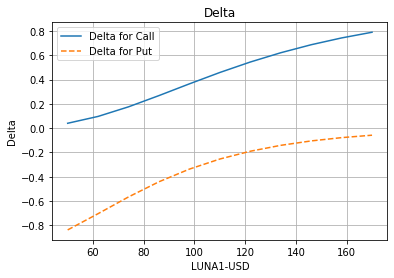

In [66]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('LUNA1-USD')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [67]:
S = np.linspace(50, 170, 51)
T = np.linspace(0.01, 0.31, 31)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 130, T[i], 0.0172, 0, 1.66, 'call')

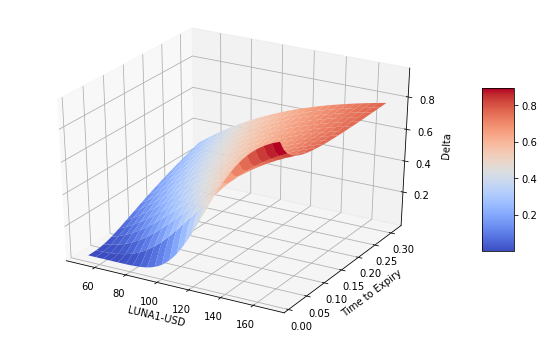

In [68]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LUNA1-USD')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma 

In [56]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [57]:
gamma(106.02, 130, 1/12, 0.0172, 0, 1.66, 'call')

0.007722161824006006

In [58]:
gamma(106.02, 90, 1/12, 0.0172, 0, 1.66, 'put')

0.006619598773325064

In [69]:
S = np.linspace(50,170,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 130, 1/12, 0.0172, 0, 1.66, 'call')

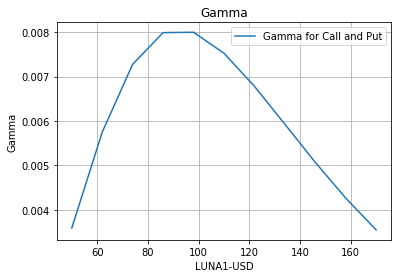

In [70]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('LUNA1-USD')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

# Surface of Gamma

In [71]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma


In [72]:
S = np.linspace(50, 170, 51)
T = np.linspace(0.5, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 130, T[i], 0.0172, 0, 1.07, 'call')

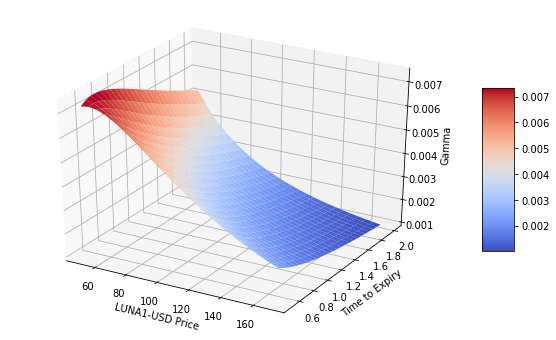

In [73]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LUNA1-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Speed

In [74]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [75]:
speed(106.02, 130, 1/12, 0.0172, 0, 1.66, 'call')

-1.2999972531137962e-05

In [78]:
speed(106.02, 90, 1/12, 0.0172, 0, 1.66, 'put')

-4.000683141574317e-05

In [90]:
S = np.linspace(50,170,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 130, 1/12, 0.0172, 0, 1.66, 'call')

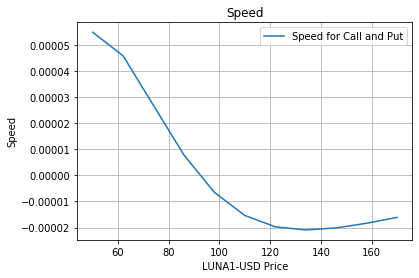

In [91]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('LUNA1-USD Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

# Surface of Speed

In [93]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [94]:
S = np.linspace(50, 170, 101)
T = np.linspace(0.5, 2, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 130, T[i], 0.0172, 0, 1.66, 'call')

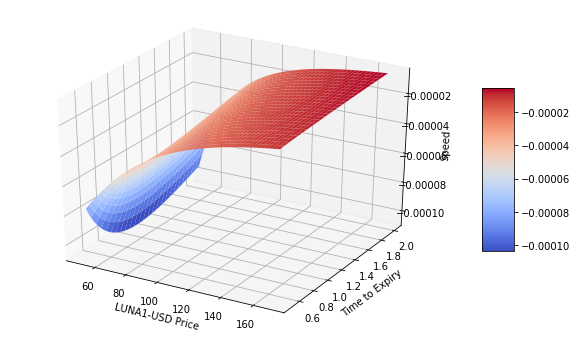

In [95]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LUNA1-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Theta

In [96]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [97]:
theta(106.02, 130, 1/12, 0.0172, 0, 1.66, 'call')

120.15861071734784

In [98]:
theta(106.02, 90, 1/12, 0.0172, 0, 1.66, 'put')

103.2245307141488

In [99]:
T = np.linspace(1,31,31)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(106.02, 130, T[i], 0.0172, 0, 1.66, 'call')
    Theta_Put [i] = theta(106.02, 90, T[i], 0.0172, 0, 1.66, 'put')

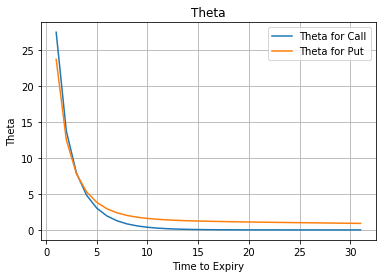

In [100]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

# Surface of Theta

In [101]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [102]:
S = np.linspace(50, 170, 101)
T = np.linspace(1, 31, 31)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 130, T[i], 0.0172, 0, 1.66, 'call')

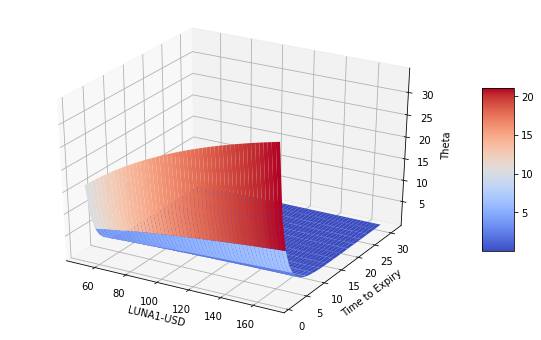

In [103]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LUNA1-USD')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Rho

In [104]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [105]:
rho(106.02, 130, 1/12, 0.0172, 0, 1.66, 'call')

2.7471419180108745

In [106]:
rho(106.02, 90, 1/12, 0.0172, 0, 1.66, 'put')

-3.430751432446856

In [107]:
r = np.linspace(0,0.1,50)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(106.02, 130, 1/12, r[i], 0, 1.66, 'call')
    Rho_Put [i] = rho(106.02, 90, 1/12, r[i], 0, 1.66, 'put')

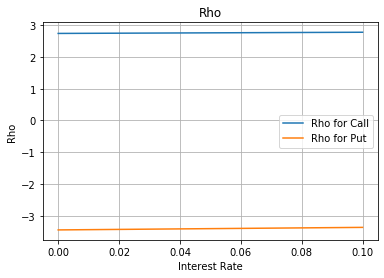

In [108]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

# Surface of Rho

In [109]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [110]:
S = np.linspace(50, 170, 101)
T = np.linspace(0.5, 2, 101)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 130, T[i], 0.0172, 0, 1.66, 'call')

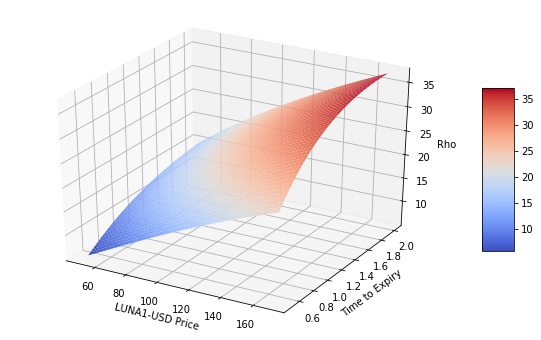

In [111]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LUNA1-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);